### This document contains all the scripts that we used to analyse the Booter Ecosystem. Part of the analyses were included in the (under reviewing process) academic article **"Quiet Dogs Can Bite: What Booters We Should Go After? And Which Are Our Mitigation Options?"** 

### The great advantage of this document format is that is written using [Jupyter Notebook](http://jupyter.org), which allows anyone to easily understand, reproduce, and extend our analysis and results.

### Please do not hesitate to contact us if you find any mistake [(j.j.santanna@utwente.nl).](mailto:j.j.santanna@utwente.nl)

## Index:
1. General Required Libraries
2. Reading the (input) Booter list (from a file OR directly from booterblacklist.com)

3. Collecting and Analysing Website Alexa Ranking
    1. Required Libraries 
    2. Defining get_alexa_rank()
    3. Testing get_alexa_rank() 
    4. Running get_alexa_rank() for the Booter list
    5. Reading the output of get_alexa_rank() for Booters the Booter list
    6. Analysing Booter Website Alexa Ranking (scatter plot)

4. Collecting and Analysing WHOIS Information
  1. Required Libraries
  2. Defining get_whois_info()
  3. Testing get_whois_info()
  4. Running get_whois_info() for the Booters List
  5. Reading the output of get_whois_info() for the Booter list
  6. Analysing the Name Servers
  7. Analysing Domain Registrars (pie chart)
  8. Analysing Domain Registrars (stacked bars)
  9. Analysing Domain Registrars (stacked bars & internal legend)
  10. Analysing Domain Creation & Expiration (scatter plot)

5. Analysing the Top Ranked Booters 
  1. Defining top ranked Booters (Alexa rank < 3M)
  2. Manually identifying top ranked Booters outliers
  3. Removing top ranked Booters outliers
  4. Analysing the Top Ranked Booters (scatter plot)
  5. Analysing top ranked Booters Domain Registration and Expiration Date (scatter plot)
  6. Analysing Top Ranked Booter Prices (box plot)
  7. Analysing Top Ranked Booter Attack Power (bar plot)
  8. Combining Top Booter (1) Web Rank, (2) Price Range, (3) Max Attack Range, and (4) Creation & Expiration Domain Dates

6. Analysing Top Level Domain (TLDs) (pie chart)

7. Analysing Booter Domain Name Composition (pie chart)

8. Combining TLD Analysis and Domain Name Composition (stacked bar)

9. Collecting IP addresses 
  1. Required Libraries
  2. Defining get_ip()
  3. Testing get_ip()
  4. Running get_ip() for the Booters List
  5. Reading the output get_ip() for the Booters List

10. Collecting and Analysing Autonomous Systems (ASes)
  1. Required Libraries
  2. Defining iptoasn()
  3. Creating a bulk resquest for whois.cymru.com
  4. Running iptoasn() for the Booters List
  5. Reading the output of iptoasn() for the Booters List
  6. Combining IP addresses and ASes for the Booters List
  7. Analysing ASes (donut chart)
  8. Analysing ASes (stacked bars)
  9. Analysing ASes (stacked bars & internal legend)
  10. Analysing Booters protected by 9 most known CBSPs

11. Collecting and Analysing ASes Behind CBSPs
  1. Defining getip_cloudpiercer_scanid()
  2. Testing getip_cloudpiercer_scanid()
  3. Running getip_cloudpiercer_scanid() for Booter Domain in CloudFlare
  4. Creating a bulk resquest for whois.cymru.com
  5. Running iptoasn() for the IPs revealed by CloudPiercer of Booters in CloudFlare
  6. Reading the output of iptoasn() for the IPs revealed by CloudPiercer of Booters in CloudFlare
  7. Removing IPs that resolved into a CloudFlare AS
  8. Getting the most updated (recent date) AS related to Booter IPs
  9. Analysing ASes Behind CloudFlare (stacked bar)
  10. Analysing ASes Behind CloudFlare (stacked bar & internal legend)
  11. Combining ASes in general and ASes behind CloudFlare (stacked bar)
  12. Combining all ASes and explain the process (stacked bar & internal legend)
  13. MANUAL test if de facto all the IPs found by CloudPiercer and resolved by TeamCymru are inside Cloudfare

# 1. General Required Libraries 

In [1]:
import pandas as pd #more info at http://pandas.pydata.org/
import numpy as np #more info at http://www.numpy.org/
import matplotlib.pyplot as plt #some examples for you at http://matplotlib.org/gallery.html 
from matplotlib import gridspec #more info at http://matplotlib.org/api/gridspec_api.html
import matplotlib.dates as dt
from matplotlib.patches import Rectangle
from matplotlib import ticker

from matplotlib_venn import *
%matplotlib inline 

plt.style.use('ggplot') #For improving the visualization style (options: grayscale, bmh, dark_background, ggplot, and fivethirtyeight)

import re

import warnings
warnings.filterwarnings('ignore') #To avoid showing annoying warns

from IPython.display import display

output_figures = 'figs/'
# output_figures = '../../figs/' #if generating already in the paper folder

# 2. Reading the (input) Booter list (from a file)

In [2]:
df = pd.read_csv('booterblacklist_latest.txt', names = ['booter'])

# 3. Collecting and Analysing Website Alexa Ranking

## 3.1. Required Libraries

In [3]:
import cfscrape
from lxml import etree
import datetime
import os.path

## 3.2. Defining get_alexa_rank()

In [4]:
def get_alexa_rank(domain):
    url="http://www.alexa.com/siteinfo/"+domain
    scraper = cfscrape.create_scraper()
    scraped_html=scraper.get(url).content
    html_tree = etree.HTML(scraped_html)

    try: 
        rank_current=float(html_tree.xpath("//strong[@class='metrics-data align-vmiddle']/text()")[1].strip().replace(",",""))
    except:
        rank_current=np.nan

    rank_3months_variation=""
    try:
        rank_3months_variation=-1*float(html_tree.xpath("//span[@class='align-vmiddle change-wrapper change-up change-r2']/text()")[0].strip().replace(",",""))
    except:
        pass
    try:
        rank_3months_variation=float(html_tree.xpath("//span[@class='align-vmiddle change-wrapper change-down color-gen2 change-r2']/text()")[0].strip().replace(",",""))
    except:
        pass
    if rank_3months_variation=="":
        rank_3months_variation=np.nan
    
    return str(rank_current)+";"+str(rank_3months_variation)

## 3.3. Testing get_alexa_rank() 

In [5]:
get_alexa_rank('utwente.nl')

'14814.0;1265.0'

## 3.4. Running get_alexa_rank() for the Booter list

In [6]:
measurement_date=datetime.datetime.now()

if (os.path.exists('enrichments/domain_alexa_rank.txt')== False):
    f = open('enrichments/domain_alexa_rank.txt', 'w')
    for i in df['booter'].unique():
        alex_rank=get_alexa_rank(i)
        print(i,str(alex_rank),sep=';') #Debugging purpose
        print(i,str(alex_rank),sep=';',file=f)
        time.sleep(random.randint(1,3)) #adding some random sleep time
        f.flush()
    f.close()
else:
    print("The list of domains was already checked.")

The list of domains was already checked.


## 3.5. Reading the output of get_alexa_rank() for Booters the Booter list

In [7]:
df_alexa = pd.read_csv('enrichments/domain_alexa_rank.txt',\
                        names = ['booter','rank_current','rank_3months_variation'],\
                        delimiter=";")

df_alexa['rank_3months_ago']=df_alexa['rank_current']+df_alexa['rank_3months_variation']

## 3.6. Analysing Booter Website Alexa Ranking (scatter plot)

In [8]:
booters_with_alexa_rank = df_alexa[~df_alexa['rank_current'].isnull()].sort_values(by='rank_current').reset_index(drop=True)
len(booters_with_alexa_rank)

127

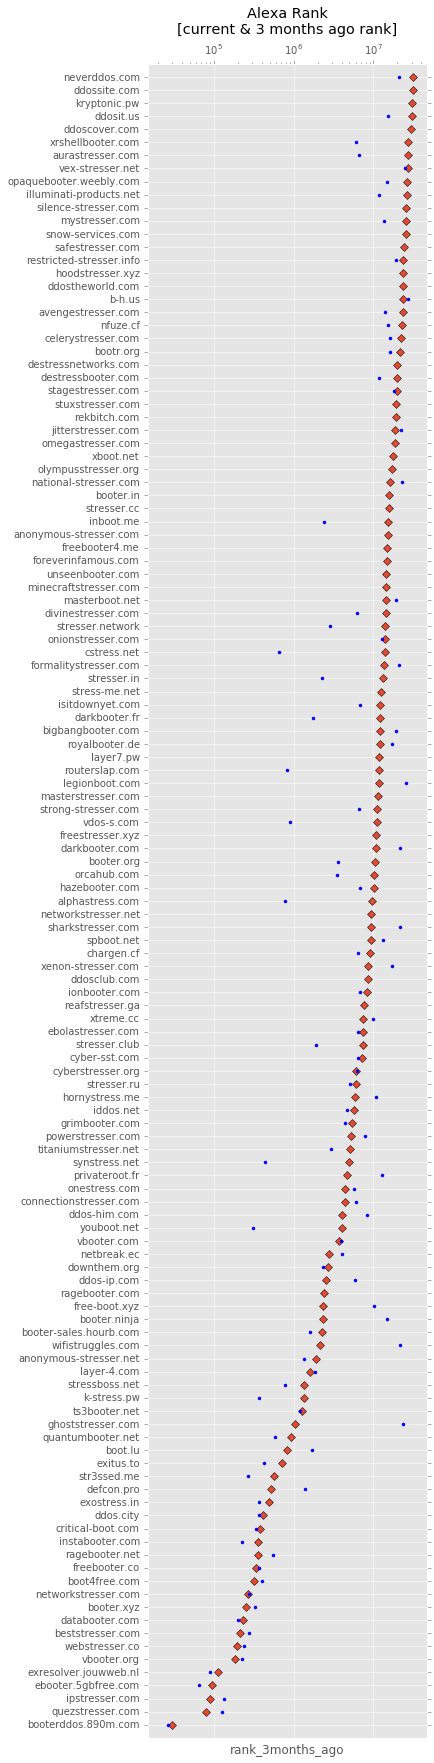

In [9]:
fig = plt.figure(figsize=(5, 30))

ax = plt.subplot2grid((1,1), (0,0))
ax.set_title('Alexa Rank\n[current & 3 months ago rank]', y=1.015)
ax.xaxis.set_ticks_position('top')
booters_with_alexa_rank.reset_index().plot(ax=ax,x='rank_current',y='index',style='D',legend=False,logx=True)
booters_with_alexa_rank.reset_index().plot(ax=ax,x='rank_3months_ago',y='index',style='.',legend=False,logx=True,color='b')
ax.set_xlim(min(booters_with_alexa_rank['rank_current'])*0.5,max(booters_with_alexa_rank['rank_current'])*1.5)
plt.yticks(booters_with_alexa_rank.index, booters_with_alexa_rank['booter'])
ax.set_ylim(-1,len(booters_with_alexa_rank.index))
# ax.set_yticklabels("")

fig.show()
fig.savefig(output_figures+'alexa_rank_scatter.eps', bbox_inches='tight',format='eps', dpi=1200)

# 4. Collecting and Analysing WHOIS Information 

## 4.1. Required Libraries

In [10]:
import pythonwhois #https://pypi.python.org/pypi/pythonwhois
import whois #https://code.google.com/archive/p/python-whois
# BulkWhois,pywhois, whoisclient (fork of python-whois)


import random
import time 

## 4.2. Defining Function get_whois_info() 

In [11]:
def get_whois_info(domain):
    try:
        whois_domain=pythonwhois.get_whois(domain)
    except:
        return str(np.nan)+";"+str(np.nan)+";"+str(np.nan)+";"+str(np.nan)+";"+str(np.nan)+";"+str(np.nan)
    
    try:
        registration_date=whois_domain['creation_date'][0]
    except:
        registration_date=np.nan
    
    try:
        expiration_date=whois_domain['expiration_date'][0]
    except:
        expiration_date=np.nan

    try:
        update_date=whois_domain['updated_date'][0]
    except:
        update_date=np.nan
        
    try:
        nameservers=whois_domain['nameservers'][0]
    except:
        nameservers=np.nan
    
    try:
        emails=whois_domain['emails'][0]
    except:
        emails=np.nan
    
    try:
        registrar=whois_domain['registrar'][0]
    except:
        registrar=np.nan
    
    return str(registration_date)+";"+str(expiration_date)+";"+str(update_date)+";"+str(nameservers)+";"+str(emails)+";"+str(registrar)

## 4.3. Testing get_whois_info()

In [12]:
get_whois_info('jairsantanna.com')

'2015-04-28 19:13:22;2019-04-28 19:13:22;2017-01-30 00:00:00;FAY.NS.CLOUDFLARE.COM;abuse@godaddy.com;GoDaddy.com, LLC'

## 4.4. Running get_whois_info() for the Booters List

In [13]:
if (os.path.exists('enrichments/domain_whois_info.txt')== False):
    f = open('enrichments/domain_whois_info.txt', 'w') # creating a new file
    for i in df['booter'].unique():
        whois_info=get_whois_info(i)
        print(i,str(whois_info),sep=';') #Debugging purpose
        print(i,str(whois_info),sep=';',file=f)
        time.sleep(random.randint(1,3)) #adding some random sleeping time
        f.flush()
    f.close()
else:
    print("The list of domains was already checked.")

The list of domains was already checked.


## 4.5. Reading the output of get_whois_info() for the Booter list

In [14]:
def date_converter(text):
    try:
        return  pd.to_datetime(text,format='%Y-%m-%d %H:%M:%S')
    except AttributeError:
        return text 

def lowercase_converter(text):
    try:
        return  text.lower()
    except AttributeError:
        return text 

df_whois_info = pd.read_csv('enrichments/domain_whois_info.txt',\
                        names = ['booter','registration_date','expiration_date','update_date','nameservers','email','registrar'],\
                        delimiter=";",\
                         converters = {'registration_date' : date_converter,
                                'expiration_date' : date_converter,
                                'update_date':date_converter,
#                                       'registrar':lowercase_converter,
#                                       'nameservers':lowercase_converter 
                                      })

## 4.6. Analysing the Name Servers (pie chart)

In [15]:
nameservers = df_whois_info['nameservers'].\
                                        dropna().\
                                        str.lower().\
                                        str.rsplit('.', 1).\
                                        str[0].\
                                        str.split('.').\
                                        str[-1].\
                                        value_counts()

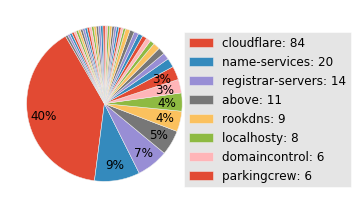

In [16]:
fig = plt.figure(figsize=(3, 3))
# fig.suptitle('Name Servers Frequency', fontsize=14)
    
ax1 = plt.subplot2grid((1,1), (0,0))

def my_autopct(pct):
    return ('%.0f' % pct)+"%" if pct > 2 else ''

nameservers.plot(ax=ax1,kind='pie', labels=None, autopct=my_autopct,startangle=120,pctdistance=0.8, labeldistance=1.05,fontsize=12)
ax1.set_ylabel("")

# For Pie Chart Better Legend boxb
labels = ['{0}: {1}'.format(i,j) for i,j in zip(nameservers.index, nameservers.values)]
legend_show_top=8
ax1.legend(ax1.patches[0:legend_show_top], 
           labels[0:legend_show_top], 
           bbox_to_anchor=(1.8, 0.9),
           fontsize=12).set_zorder(0)

fig.tight_layout()
fig.show()
fig.savefig(output_figures+'nameservers_pie.eps', bbox_inches='tight',format='eps', dpi=1200)

## 4.7. Analysing Domain Registrars (pie chart)

In [17]:
registrar = df_whois_info['registrar'].\
                                        dropna().\
                                        str.lower().\
                                        str.split(',').\
                                        str[0].\
                                        str.split().\
                                        str.get(0).\
                                        value_counts()

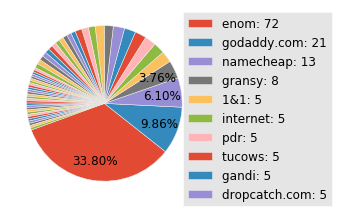

In [18]:
fig = plt.figure(figsize=(3, 3))
# fig.suptitle('Registrar Distribution', fontsize=14)
    
ax1 = plt.subplot2grid((1,1), (0,0))

def my_autopct(pct):
    return ('%.2f' % pct)+"%" if pct > 3 else ''

registrar.plot(ax=ax1,kind='pie', labels=None, autopct=my_autopct,startangle=200,pctdistance=0.75, labeldistance=1.05,fontsize=12)
ax1.set_ylabel("")

# For Pie Chart Better Legend boxb
labels = ['{0}: {1}'.format(i,j) for i,j in zip(registrar.index, registrar.values)]

legend_show_top=10

ax1.legend(ax1.patches[0:legend_show_top], 
           labels[0:legend_show_top], 
           bbox_to_anchor=(1.7, 1),
           fontsize=12).set_zorder(0)

fig.tight_layout()
fig.show()
fig.savefig(output_figures+'registrars_pie.eps', bbox_inches='tight',format='eps', dpi=1200)

## 4.8. Analysing Domain Registrars (stacked bars)

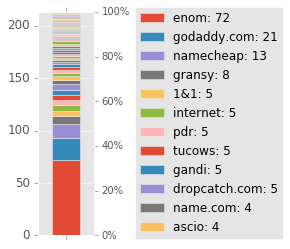

In [19]:
fig = plt.figure(figsize=(1, 4))
fig.subplots_adjust(hspace=0.5,wspace=0.3)

ax2 = plt.subplot2grid((1,1), (0,0))

ax1 = ax2.twinx()
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

registrar.to_frame().T.plot(kind='bar',ax=ax2, legend=False, stacked=True, title="",fontsize=12).set_zorder(1)
ax2.set_xlabel("")
ax2.set_ylim(0,len(df_whois_info['registrar'].dropna()))

legend_show_top=12
ax2.legend(ax2.patches[0:legend_show_top], 
           labels[0:legend_show_top], 
           bbox_to_anchor=(4.5, 1.05),
#            ['Enon:71','GoDaddy:21','NameCheap:13','Gransy:8', 'DropCatch.com:5', 'Gandy:5','Tucows:5', 'InternetBS:5','1&1:5','PublicDomainRegistry:5', 'Gandi:5','Ascio:4',]
           fontsize=12)
# .set_zorder(1)
plt.setp( ax2.get_xticklabels(), visible=False)


fig.show()
fig.savefig(output_figures+'registrars_stacked.eps', bbox_inches='tight',format='eps', dpi=1200)

## 4.9. Analysing Domain Registrars (stacked bars & internal legend)

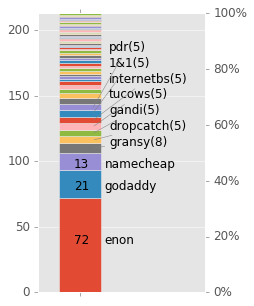

In [20]:
fig = plt.figure(figsize=(3, 5))
fig.subplots_adjust(hspace=0.5,wspace=0.3)

ax2 = plt.subplot2grid((1,1), (0,0))

ax1 = ax2.twinx()
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax1.tick_params(which='major', labelsize=12)

registrar.to_frame().T.plot(kind='bar',ax=ax2, legend=False, stacked=True, title="",fontsize=12,width = .1).set_zorder(1)
ax2.set_xlabel("")
ax2.set_ylim(0,len(df_whois_info['registrar'].dropna()))
ax2.set_xlim(-.1,0.3)

plt.setp( ax2.get_xticklabels(), visible=False)

#####MANUAL LEGEND!
ax2.text(0.06, 40,'enon',ha="left", va="center",size=12)
ax2.text(0.005, 40,'72',ha="center", va="center",size=12)

ax2.text(0.06, 81,'godaddy',ha="left", va="center",size=12)
ax2.text(0.005, 81,'21',ha="center", va="center",size=12)

ax2.text(0.06, 98,'namecheap',ha="left", va="center",size=12)
ax2.text(0.005, 98,'13',ha="center", va="center",size=12)

ax2.annotate('gransy(8)',
             (0.03,110), xycoords='data',
             xytext=(0.07,115), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)

ax2.annotate('dropcatch(5)',
             (0.03,116), xycoords='data',
             xytext=(0.07,127), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12
            )

ax2.annotate('gandi(5)',
             (0.03,121), xycoords='data',
             xytext=(0.07,139), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)

ax2.annotate('tucows(5)',
             (0.03,126), xycoords='data',
             xytext=(0.07,151), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)

ax2.annotate('internetbs(5)',
             (0.03,131), xycoords='data',
             xytext=(0.07,163), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)

ax2.annotate('1&1(5)',
             (0.03,136), xycoords='data',
             xytext=(0.07,175), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)

ax2.annotate('pdr(5)',
             (0.03,140), xycoords='data',
             xytext=(0.07,187), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)

fig.show()
fig.savefig(output_figures+'registrars_stacked_inlegend.eps', bbox_inches='tight',format='eps', dpi=1200)

## 4.10. Analysing Domain Creation & Expiration (scatter plot)

In [21]:
booters_with_creation_expiration = df_whois_info[df_whois_info['registration_date'].notnull()][df_whois_info['expiration_date'].notnull()].sort('registration_date').reset_index(drop=True)

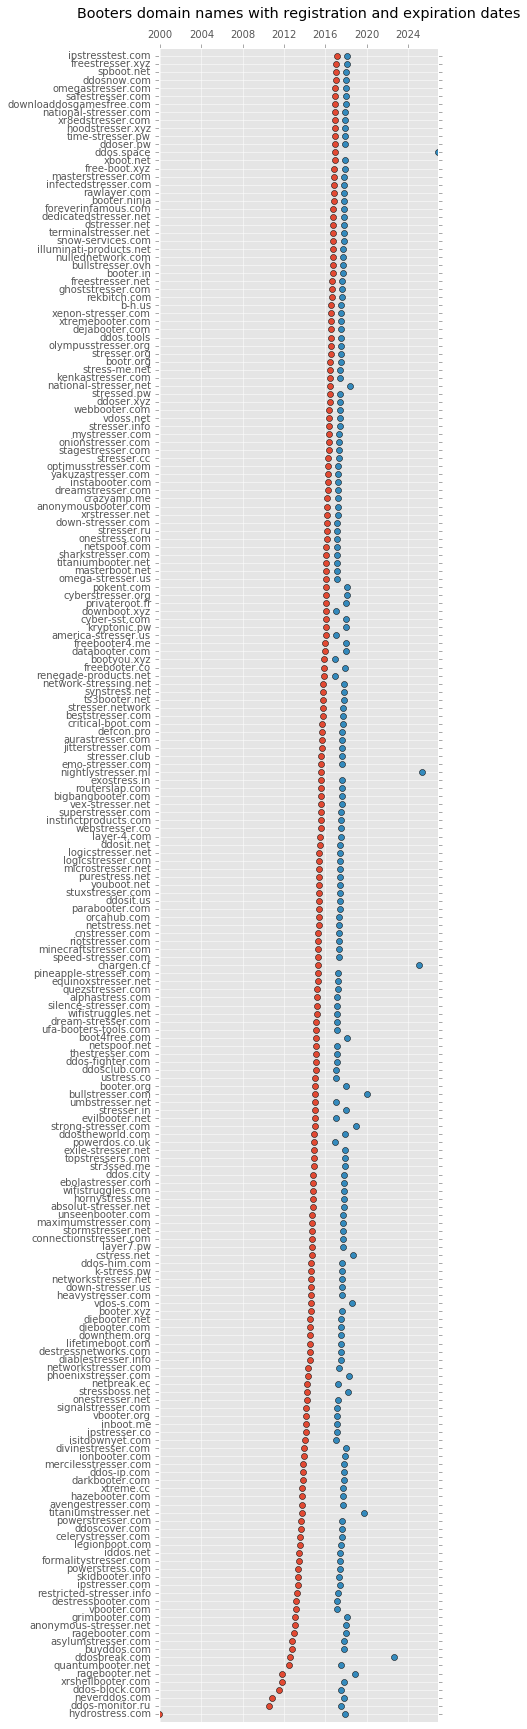

In [22]:
fig = plt.figure(figsize=(5, 30))

ax = plt.subplot2grid((1,1), (0,0))
ax.set_title('Booters domain names with registration and expiration dates', y=1.015)
ax.xaxis.set_ticks_position('top')

plt.plot_date(x=booters_with_creation_expiration['registration_date'],\
              y=booters_with_creation_expiration.index)

plt.plot_date(x=booters_with_creation_expiration['expiration_date'],\
              y=booters_with_creation_expiration.index)

plt.yticks(booters_with_creation_expiration.index, booters_with_creation_expiration['booter'])

ax.set_ylim(-1,len(booters_with_creation_expiration.index))
ax.set_xlim(min(booters_with_creation_expiration['registration_date']),max(booters_with_creation_expiration['expiration_date']))


fig.show()
fig.savefig(output_figures+'domain_creation_expiration_scatter.eps', bbox_inches='tight',format='eps', dpi=1200)

# 5. Analysing the Top Ranked Booters

## 5.1. Defining top ranked Booters (Alexa rank < 3M)

In [23]:
df_popular_booters=booters_with_alexa_rank[booters_with_alexa_rank['rank_current']<=3000000]
df_popular_booters

,booter,rank_current,rank_3months_variation,rank_3months_ago
0,booterddos.890m.com,29850.0,-3384.0,26466.0
1,quezstresser.com,78852.0,48987.0,127839.0
2,ipstresser.com,89671.0,43407.0,133078.0
3,ebooter.5gbfree.com,94591.0,-29146.0,65445.0
4,exresolver.jouwweb.nl,112394.0,-21970.0,90424.0
5,vbooter.org,185675.0,40576.0,226251.0
6,webstresser.co,197751.0,40470.0,238221.0
7,beststresser.com,212256.0,62793.0,275049.0
8,databooter.com,231747.0,-31424.0,200323.0
9,booter.xyz,251037.0,77607.0,328644.0


## 5.2. Manually identifying top ranked Booters outliers
- booterddos.890m.com (index=0)
- ebooter.5gbfree.com (index=3)
- exresolver.jouwweb.nl (index=4)
- booter-sales.hourb.com (index=30)

## 5.3. Removing top ranked Booters outliers

In [24]:
df_popular_booters.drop(df_popular_booters.index[[0,3,4,30]], inplace=True) 

## 5.4. Analysing top ranked Booters (scatter plot)

In [25]:
df_popular_booters.sort(['rank_current'], ascending=False, inplace=True)
df_popular_booters.reset_index(inplace=True,drop=True)

popular_booters_extended= pd.merge(df_popular_booters,
                                      booters_with_creation_expiration,
                                      how = 'left',
                                      left_on = 'booter',
                                      right_on = 'booter')

ranking = popular_booters_extended.iloc[::-1].index
ranking +=1

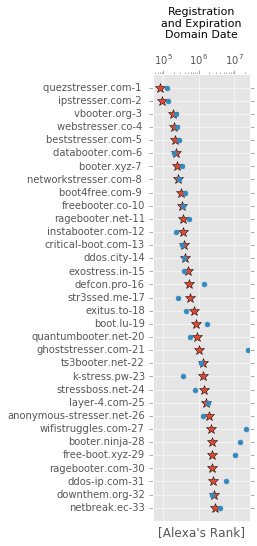

In [26]:
fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot2grid((1,4), (0,0))
ax1.set_title('Registration\nand Expiration\nDomain Date', y=1.07,size=11)
ax1.xaxis.set_ticks_position('top')

popular_booters_extended.reset_index().plot(ax=ax1,x='rank_current',y='index',style='*',legend=False,logx=True,markersize=10)
popular_booters_extended.reset_index().plot(ax=ax1,x='rank_3months_ago',y='index',style='.',legend=False,logx=True,markersize=10)

plt.yticks(popular_booters_extended.index, popular_booters_extended['booter'].str.cat(ranking.format(), sep='-'))

ax1.set_ylim(-1,len(popular_booters_extended.index))
ax1.set_xlim(min(popular_booters_extended['rank_3months_ago'])*0.4,max(popular_booters_extended['rank_current'])*10)

plt.xlabel('[Alexa\'s Rank]', fontsize=12)

fig.show()
fig.savefig(output_figures+'topranked_alexa_rank_scatter.eps', bbox_inches='tight',format='eps', dpi=1200)

## 5.5. Analysing top ranked Booters Domain Registration and Expiration Date (scatter plot)

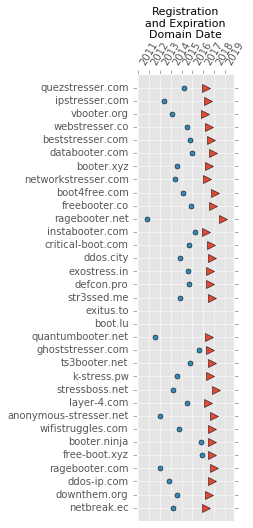

In [27]:
fig = plt.figure(figsize=(8, 8))
ax4 = plt.subplot2grid((1,4), (0,3))
ax4.set_title('Registration\nand Expiration\nDomain Date', y=1.07,size=11)
ax4.xaxis.set_ticks_position('top')

ax4.plot_date(x=popular_booters_extended['expiration_date'],\
               y=popular_booters_extended.index,marker='>',markersize=8)

ax4.plot_date(x=popular_booters_extended['registration_date'],\
              y=popular_booters_extended.index,markersize=5)


plt.yticks(popular_booters_extended.index, popular_booters_extended['booter'])

ax4.set_ylim(-1,len(popular_booters_extended.index))
ax4.set_xlim(min(popular_booters_extended['registration_date'])-pd.DateOffset(years=1),max(popular_booters_extended['expiration_date'])+pd.DateOffset(years=1))
plt.setp(ax4.get_xticklabels(), rotation=60,ha='left')

ax4.yaxis.set_ticks(popular_booters_extended.index)


fig.show()
fig.savefig(output_figures+'topranked_domain_creation_expiration_scatter.eps', bbox_inches='tight',format='eps', dpi=1200)

## 5.6. Analysing Top Ranked Booter Prices (box plot)
[data collected manually]

In [28]:
df_prices = pd.read_csv('prices.csv',sep=';').reset_index(drop=True)
df_prices = df_prices[df_prices.columns[::-1]]

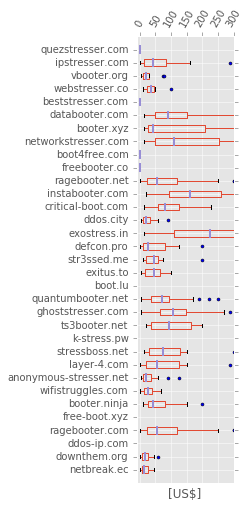

In [29]:
fig = plt.figure(figsize=(8, 8))
ax2 = plt.subplot2grid((1,4), (0,1))
ax2.xaxis.set_ticks_position('top')
df_prices.boxplot(vert=False,ax=ax2, 
#                   patch_artist=True,
                 flierprops={'marker': '.'},
                 whiskerprops={'linestyle':'-'},
                 medianprops={'linewidth':'2'})

ax2.set_xlim(-10,300)
plt.xlabel('[US$]', fontsize=12)
plt.setp(ax2.get_xticklabels(), rotation=60,ha='center')

plt.yticks(popular_booters_extended.index+1, df_prices.columns)
ax2.set_ylim(0,len(df_prices.columns)+1)

plt.show()
fig.savefig(output_figures+'topranked_prices_boxplot.eps', bbox_inches='tight',format='eps', dpi=1200)

## 5.7. Analysing Top Ranked Booter Attack Power (bar plot)

In [30]:
df_attack_power = pd.read_csv('attack_power.csv',sep=';').max().iloc[::-1].reset_index()
df_attack_power.columns = ['booter', 'max_attack_power']

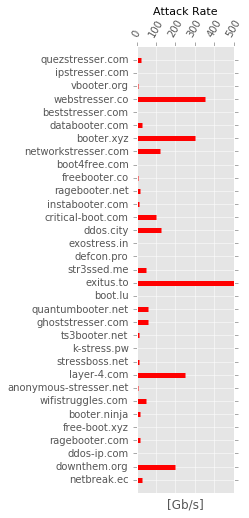

In [31]:
fig = plt.figure(figsize=(8, 8))
ax3 = plt.subplot2grid((1,4), (0,2))
ax3.set_title('Attack Rate', y=1.06,size=11)

ax3.xaxis.set_ticks_position('top')

ax3.hlines(df_attack_power.index, 0, df_attack_power['max_attack_power'],linewidths=5,color='r')

ax3.set_xlim(0,max(df_attack_power['max_attack_power'].dropna()))
plt.xlabel('[Gb/s]', fontsize=12)
plt.setp(ax3.get_xticklabels(), rotation=60,ha='center')

plt.yticks(popular_booters_extended.index, df_attack_power['booter'])
ax3.set_ylim(-1,len(df_attack_power['booter']))

plt.show()
fig.savefig(output_figures+'topranked_maxattack_bar.eps', bbox_inches='tight',format='eps', dpi=1200)

# 5.8. Combining Top Booter (1) Web Rank, (2) Price Range, (3) Max Attack Range, and (4) Creation & Expiration Domain Dates 

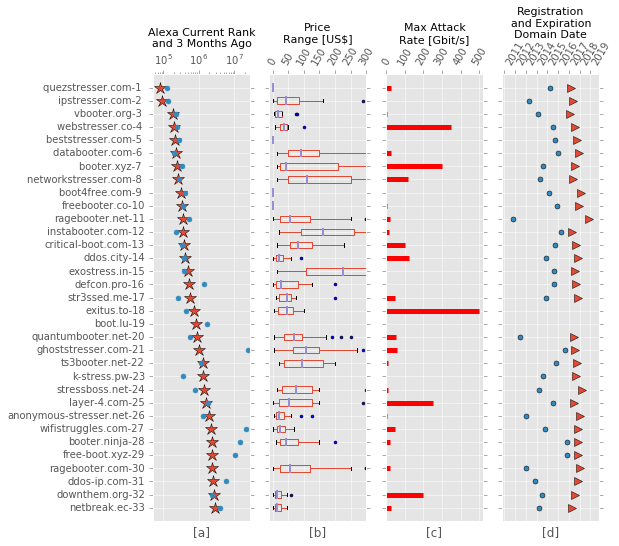

In [32]:
import matplotlib.dates as dates

fig = plt.figure(figsize=(8, 8))

ax1 = plt.subplot2grid((1,4), (0,0))
ax1.set_title('Alexa Current Rank\nand 3 Months Ago', y=1.05,size=11)
ax1.xaxis.set_ticks_position('top')

popular_booters_extended.reset_index().plot(ax=ax1,x='rank_current',y='index',style='*',legend=False,logx=True,markersize=12)
popular_booters_extended.reset_index().plot(ax=ax1,x='rank_3months_ago',y='index',style='.',legend=False,logx=True,markersize=10)

plt.yticks(popular_booters_extended.index, popular_booters_extended['booter'].str.cat(ranking.format(), sep='-'))

ax1.set_ylim(-1,len(popular_booters_extended.index))
ax1.set_xlim(min(popular_booters_extended['rank_3months_ago'])*0.4,max(popular_booters_extended['rank_current'])*10)

plt.xlabel('[a]', fontsize=12)

######################################
#PRICE RANGE
ax2 = plt.subplot2grid((1,4), (0,1))
ax2.set_title('Price\nRange [US$]', y=1.06,size=11)
ax2.xaxis.set_ticks_position('top')
df_prices.boxplot(vert=False,ax=ax2, 
#                   patch_artist=True,
                 flierprops={'marker': '.'},
                 whiskerprops={'linestyle':'-'},
                 medianprops={'linewidth':'2'})

ax2.set_xlim(-10,300)
plt.xlabel('[b]', fontsize=12)
plt.setp(ax2.get_xticklabels(), rotation=60,ha='center')

plt.yticks(popular_booters_extended.index+1, df_prices.columns)
ax2.set_ylim(0,len(df_prices.columns)+1)
ax2.set_yticklabels([])

######################################
# ATTACK RATE
ax3 = plt.subplot2grid((1,4), (0,2))
ax3.set_title('Max Attack\nRate [Gbit/s]', y=1.06,size=11)

ax3.xaxis.set_ticks_position('top')

ax3.hlines(df_attack_power.index, 0, df_attack_power['max_attack_power'],linewidths=5,color='r')

ax3.set_xlim(0,max(df_attack_power['max_attack_power'].dropna())+20)
plt.xlabel('[c]', fontsize=12)
plt.setp(ax3.get_xticklabels(), rotation=60,ha='center')

plt.yticks(popular_booters_extended.index, df_attack_power['booter'])
ax3.set_ylim(-1,len(df_attack_power['booter']))
ax3.set_yticklabels([])
######################################
#DOMAIN REGISTRATION
ax4 = plt.subplot2grid((1,4), (0,3))
ax4.set_title('Registration\nand Expiration\nDomain Date', y=1.07,size=11)
ax4.xaxis.set_ticks_position('top')

ax4.plot_date(x=popular_booters_extended['expiration_date'],\
               y=popular_booters_extended.index,marker='>',markersize=8)

ax4.plot_date(x=popular_booters_extended['registration_date'],\
              y=popular_booters_extended.index,markersize=5)


plt.yticks(popular_booters_extended.index, popular_booters_extended['booter'])

ax4.set_ylim(-1,len(popular_booters_extended.index))
ax4.set_xlim(min(popular_booters_extended['registration_date'])-pd.DateOffset(years=1),max(popular_booters_extended['expiration_date'])+pd.DateOffset(years=1))
plt.setp(ax4.get_xticklabels(), rotation=60,ha='left')

ax4.yaxis.set_ticks(popular_booters_extended.index)
ax4.set_yticklabels([])
plt.xlabel('[d]', fontsize=12)

######################################
# ax1.annotate('', xytext=(-0.9, 0.68), xy=(-0.9, 0.12), xycoords='axes fraction', 
#             arrowprops=dict(arrowstyle="<->", color='gray',connectionstyle='bar,fraction=0.2'))

fig.show()
fig.savefig(output_figures+'topranked_general.eps', bbox_inches='tight',format='eps', dpi=1200)

# 6. Analysing Top Level Domain (TLDs) (pie chart)

In [33]:
df['tld']=df['booter'].str.split('.').str[-1]
freq_tld = df['tld'].value_counts()

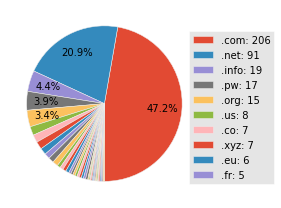

In [34]:
fig = plt.figure(figsize=(3, 3))
fig.suptitle('Booter Domain Names in TLDs', fontsize=14)
    
ax1 = plt.subplot2grid((1,1), (0,0))

def my_autopct(pct):
    return ('%.1f' % pct)+"%" if pct > 3 else ''

freq_tld.plot(ax=ax1,kind='pie', labels=None, autopct=my_autopct,startangle=270,pctdistance=0.75, labeldistance=1.05)
ax1.set_ylabel("")


# Legend boxb
labels = ['.{0}: {1}'.format(i,j) for i,j in zip(freq_tld.index, freq_tld.values)]
legend_show_top=10
ax1.legend(ax1.patches[0:legend_show_top], 
           labels[0:legend_show_top], 
           bbox_to_anchor=(1.4, 0.9),
           fontsize=10)

fig.tight_layout()
fig.show()
fig.suptitle('')
fig.savefig(output_figures+'tlds_pie.eps', bbox_inches='tight',format='eps', dpi=1200)

In [35]:
freq_tld['nl']*100/435

1.1494252873563218

# 7. Analysing Booter Domain Name Composition (pie chart)

In [36]:
stress_dn=df['booter'][df['booter'].str.contains('stresser')]
boot_dn=df['booter'][df['booter'].str.contains('booter')]
ddos_dn=df['booter'][df['booter'].str.contains('ddos')]
concat_main_dn=pd.concat([stress_dn, boot_dn, ddos_dn])

other_dn=df['booter'][df['booter'].isin(concat_main_dn)==False]

domain_name_regex = pd.Series([len(stress_dn),
                               len(boot_dn),
                               len(ddos_dn),
                               len(other_dn)],\
                              index=['stress','boot','ddos','others'])

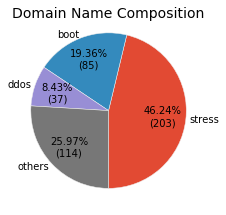

In [37]:
fig = plt.figure(figsize=(3, 3))
fig.suptitle('Domain Name Composition', fontsize=14)

ax1 = plt.subplot2grid((1,1), (0,0))

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct

domain_name_regex.plot(ax=ax1,
                       kind='pie', 
                       autopct=make_autopct(domain_name_regex.values),
                       startangle=270,
                       pctdistance=0.7,
                      labeldistance=1.05)
ax1.set_ylabel("")

fig.tight_layout()
fig.show()

fig.savefig(output_figures+'wildcards_pie.eps', bbox_inches='tight',format='eps', dpi=1200)

# 8. Combining TLD Analysis and Domain Name Composition (stacked bar)

In [38]:
df['wildcards2']=np.nan

df['wildcards2'][df['wildcards2'].isnull() & df['booter'].str.contains('stresser')]="stresser"
df['wildcards2'][df['wildcards2'].isnull() & df['booter'].str.contains('booter')]="booter"
df['wildcards2'][df['wildcards2'].isnull() & df['booter'].str.contains('ddos')]="ddos"
df['wildcards2'][df['wildcards2'].isnull()]="others"

order = ['stresser', 'booter', 'ddos', 'others']

wildcards2_tlds = df[['tld','wildcards2']].pivot_table(index='wildcards2',
                                                       columns='tld', 
                                                       aggfunc=len)

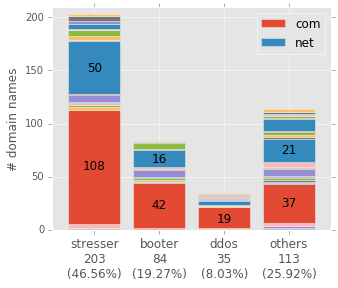

In [39]:
fig = plt.figure(figsize=(5, 4))
fig.subplots_adjust(hspace=0.5,wspace=0.3)

ax1 = plt.subplot2grid((1,1), (0,0))
# wildcards1_tlds.plot(kind='bar',ax=ax1, legend=False, stacked=True, title="",width = .3)
wildcards2_tlds.ix[order].plot(kind='bar',ax=ax1, stacked=True, title="",width = .8)

ax1.set_ylim(0,210)

ax1.set_xlabel("")
ax1.set_ylabel("# domain names")
ax1.xaxis.set_tick_params(labelsize=12)

ax1.set_xticklabels(['stresser\n'+str(len(df['wildcards2'][df['wildcards2']=='stresser']))+'\n'+str('({:.2f}%)'.format(len(df['wildcards2'][df['wildcards2']=='stresser'])*100/len(df))),
                     'booter\n'+str(len(df['wildcards2'][df['wildcards2']=='booter']))+'\n'+str('({:.2f}%)'.format(len(df['wildcards2'][df['wildcards2']=='booter'])*100/len(df))),
                     'ddos\n'+str(len(df['wildcards2'][df['wildcards2']=='ddos']))+'\n'+str('({:.2f}%)'.format(len(df['wildcards2'][df['wildcards2']=='ddos'])*100/len(df))),
                     'others\n'+str(len(df['wildcards2'][df['wildcards2']=='others'])-1)+'\n'+str('({:.2f}%)'.format((len(df['wildcards2'][df['wildcards2']=='others'])-1)*100/len(df)))],
                    rotation=0)

ax1.legend(['com', 'net'])

# Semi-automatic ANNOTATION 
ax1.text(0, 60,str(int(wildcards2_tlds.ix['stresser', 'com'])),ha="center", va="center",size=12)
ax1.text(0, 152,str(int(wildcards2_tlds.ix['stresser', 'net'])),ha="center", va="center",size=12)
ax1.text(1, 23,str(int(wildcards2_tlds.ix['booter', 'com'])),ha="center", va="center",size=12)
ax1.text(1, 67,str(int(wildcards2_tlds.ix['booter', 'net'])),ha="center", va="center",size=12)
ax1.text(2, 10,str(int(wildcards2_tlds.ix['ddos', 'com'])),ha="center", va="center",size=12)
ax1.text(3, 25,str(int(wildcards2_tlds.ix['others', 'com'])),ha="center", va="center",size=12)
ax1.text(3, 75,str(int(wildcards2_tlds.ix['others', 'net'])),ha="center", va="center",size=12)

fig.show()
fig.savefig(output_figures+'tlds_wildcards_stacked.eps', bbox_inches='tight',format='eps', dpi=1200)

# 9. Collecting IP addresses  

## 9.1. Required Libraries

In [77]:
import socket

## 9.2. Defining get_ip()

In [78]:
def get_ip(domain):
    try:
        return str(socket.gethostbyname(domain))
    except:
        return str(np.nan)

## 9.3. Testing get_ip()

In [79]:
get_ip('jairsantanna.com')

'104.28.3.97'

## 9.4. Running get_ip() for the Booters List

In [80]:
if (os.path.exists('enrichments/domain_ip.txt')== False):
    f = open('enrichments/domain_ip.txt', 'w')
    for i in df['booter'].unique():
        domain_ip=get_ip(i)
        print(i,str(domain_ip),sep=';') #Debugging purpose
        print(i,str(domain_ip),sep=';',file=f)
        time.sleep(random.randint(1,3)) #adding some random sleep time
        f.flush()
    f.close()
else:
    print("The list of domains was already checked.")

The list of domains was already checked.


## 9.5. Reading the output get_ip() for the Booters List

In [43]:
df_ips = pd.read_csv('enrichments/domain_ip.txt', names = ['booter','ip'], delimiter=";")

# 10. Collecting and Analysing Autonomous Systems (ASes)

## 10.1. Required Libraries

In [45]:
import subprocess
import os.path
import random
import time 

## 10.2. Defining iptoasn()

In [46]:
def iptoasn(iplist_teamcymruformat_filelocation,outputfile):
    cat = subprocess.Popen(['cat', iplist_teamcymruformat_filelocation], 
                            stdout=subprocess.PIPE)
    print(cat)
    netcat = subprocess.Popen(['netcat', 'whois.cymru.com', '43'],
                              stdin=cat.stdout,
                              stdout=outputfile)
    print (netcat)
    time.sleep(3) #for some reason the poll does not work! This was the way to overcome the waiting time.
    
    return netcat.stdout    

## 10.3. Creating a bulk resquest for whois.cymru.com

In [47]:
if (os.path.exists('enrichments/iptoasn_request.txt')== False):
    iptoasn_request = open('enrichments/iptoasn_request.txt', 'w+')
    iptoasn_request.write('begin\nverbose\n')
    pd.Series(df_ips['ip'].dropna().unique()).to_csv(iptoasn_request,header=False,index=False,sep="\t") 
    iptoasn_request.write('end')
    iptoasn_request.close()
else:
    print("The input file was already created.")

The input file was already created.


## 10.4. Running iptoasn() for the Booters List

In [48]:
if (os.path.exists('enrichments/iptoasn_response.txt')== False):
    iptoasn_response = open('enrichments/iptoasn_response.txt', 'w+')
    iptoasn('enrichments/iptoasn_request.txt',iptoasn_response)
    iptoasn_response.close()
else:
    print("The list of domains was already checked.")

The list of domains was already checked.


## 10.5. Reading the output of iptoasn() for the Booters List

In [49]:
df_ips_iptoasn = pd.read_csv('enrichments/iptoasn_response.txt',\
                             skiprows=1,\
                             delimiter="\s+\|\s",\
                             names = ['asn', 'ip', 'bgp_prefix', 'country','registry','info_date','as_name'])



## 10.6. Combining IP addresses and ASes for the Booters List 

In [ ]:
df_ips_extended= pd.merge(df_ips,df_ips_iptoasn,
                          how = 'left',
                          left_on = 'ip',
                          right_on = 'ip')

## 10.7. Analysing ASes (donut chart)

In [82]:
asn_all=df_ips_extended['as_name']\
                            .dropna()\
                            .str.split(' - ')\
                            .str[0]\
                            .str.split(',')\
                            .str[0]\
                            .str.strip()\
                            .str.split('-')\
                            .str[0]\
                            .str.lower()
asn=asn_all.value_counts()

# Correction for godaddy (which with our processing became 'as')
asn.index=asn.index.str.replace('as','godaddy',n=1)

#OLD ANALYSIS. Problem: doesn't differenciate btw AMAZON-02 and AMAZON-AES
#asn=df_ips_extended.groupby(['asn','as_name']).size().order(ascending=False)

len(asn_all),len(asn)

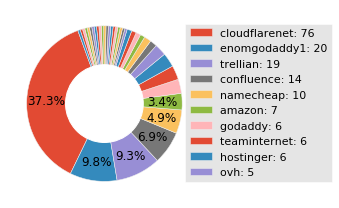

In [54]:
fig = plt.figure(figsize=(3, 3))
# fig.suptitle('Autonomous System Distribution', fontsize=14)
    
ax1 = plt.subplot2grid((1,1), (0,0))

def my_autopct(pct):
    return ('%.1f' % pct)+"%" if pct > 3 else ''

asn.plot(ax=ax1,kind='pie', labels=None, autopct=my_autopct,startangle=110,pctdistance=0.75, labeldistance=1.05,fontsize=12)
ax1.set_ylabel("")

# For Pie Chart Better Legend boxb
labels = ['{0}: {1}'.format(i,j) for i,j in zip(asn.index, asn.values)]
legend_show_top=10
ax1.legend(ax1.patches[0:legend_show_top], 
           labels[0:legend_show_top], 
           bbox_to_anchor=(1.7, .94),
           fontsize=11)

centre_circle = plt.Circle((0,0),0.5,color='white', fc='white',linewidth=1)
fig.gca().add_artist(centre_circle)

fig.tight_layout()
fig.show()
fig.savefig(output_figures+'ases_donut.eps', bbox_inches='tight',format='eps', dpi=1200)

## 10.8. Analysing ASes (stacked bars)

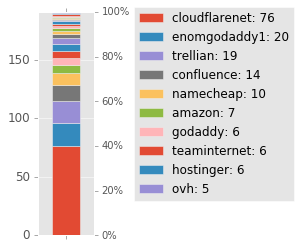

In [55]:
fig = plt.figure(figsize=(1, 4))
fig.subplots_adjust(hspace=0.5,wspace=0.3)

ax2 = plt.subplot2grid((1,1), (0,0))

ax1 = ax2.twinx()
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

asn.to_frame().T.plot(kind='bar',ax=ax2, legend=False, stacked=True, title="",fontsize=12).set_zorder(1)
ax2.set_xlabel("")
ax2.set_ylim(0,len(df_ips_extended.dropna()))

legend_show_top=10
ax2.legend(ax2.patches[0:legend_show_top], 
         labels[0:legend_show_top], 
           bbox_to_anchor=(4.7, 1.05),
           fontsize=12)
# 
plt.setp( ax2.get_xticklabels(), visible=False)


fig.show()
fig.savefig(output_figures+'ases_scatter.eps', bbox_inches='tight',format='eps', dpi=1200)

## 10.9. Analysing ASes (stacked bars & internal legend)

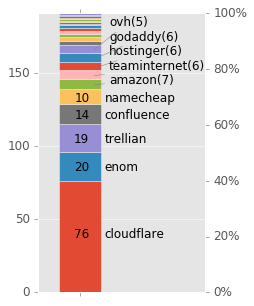

In [83]:
fig = plt.figure(figsize=(3, 5))
fig.subplots_adjust(hspace=0.5,wspace=0.3)

ax2 = plt.subplot2grid((1,1), (0,0))

ax1 = ax2.twinx()
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax1.tick_params(which='major', labelsize=12)


asn.to_frame().T.plot(kind='bar',ax=ax2, legend=False, stacked=True, title="",fontsize=12,width=0.1).set_zorder(1)
ax2.set_xlabel("")
ax2.set_ylim(0,len(df_ips_extended.dropna()))
ax2.set_xlim(-.1,0.3)

plt.setp( ax2.get_xticklabels(), visible=False)

ax2.text(0.06, 40,'cloudflare',ha="left", va="center",size=12)
ax2.text(0.005, 40,'76',ha="center", va="center",size=12)

ax2.text(0.06, 86,'enom',ha="left", va="center",size=12)
ax2.text(0.005, 86,'20',ha="center", va="center",size=12)

ax2.text(0.06, 105,'trellian',ha="left", va="center",size=12)
ax2.text(0.005, 105,'19',ha="center", va="center",size=12)

ax2.text(0.06, 121,'confluence',ha="left", va="center",size=12)
ax2.text(0.005, 121,'14',ha="center", va="center",size=12)

ax2.text(0.06, 133,'namecheap',ha="left", va="center",size=12)
ax2.text(0.005, 133,'10',ha="center", va="center",size=12)

ax2.annotate('amazon(7)',
             (0.03,142), xycoords='data',
             xytext=(0.07,145), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)

ax2.annotate('teaminternet(6)',
             (0.03,148), xycoords='data',
             xytext=(0.07,155), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)

ax2.annotate('hostinger(6)',
             (0.03,153), xycoords='data',
             xytext=(0.07,165), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)

ax2.annotate('godaddy(6)',
             (0.03,159), xycoords='data',
             xytext=(0.07,175), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
             size=12)

ax2.annotate('ovh(5)',
             (0.03,165), xycoords='data',
             xytext=(0.07,185), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)



fig.show()
fig.savefig(output_figures+'ases_scatter_inlegend.eps', bbox_inches='tight',format='eps', dpi=1200)

## 10.10. Analysing Booters protected by 9 most known CBSPs
Based on: Mattijs Jonker, Anna Sperotto, Roland van Rijswijk-Deij, Ramin Sadre, and Aiko Pras. 2016. Measuring the Adoption of DDoS Protection Services. In Proceedings of the 2016 ACM on Internet Measurement Conference (IMC '16). ACM, New York, NY, USA, 279-285. DOI: https://doi.org/10.1145/2987443.2987487 

In [84]:
len(df_ips_extended[df_ips_extended['as_name'].str.contains('cloudflare',flags=re.IGNORECASE)==True]),\
len(df_ips_extended[df_ips_extended['as_name'].str.contains('akamai',flags=re.IGNORECASE)==True]),\
len(df_ips_extended[df_ips_extended['as_name'].str.contains('centurylink',flags=re.IGNORECASE)==True]),\
len(df_ips_extended[df_ips_extended['as_name'].str.contains('dosarrest',flags=re.IGNORECASE)==True]),\
len(df_ips_extended[df_ips_extended['as_name'].str.contains('f5',flags=re.IGNORECASE)==True]),\
len(df_ips_extended[df_ips_extended['as_name'].str.contains('incapsula',flags=re.IGNORECASE)==True]),\
len(df_ips_extended[df_ips_extended['as_name'].str.contains('level3',flags=re.IGNORECASE)==True]),\
len(df_ips_extended[df_ips_extended['as_name'].str.contains('neustar',flags=re.IGNORECASE)==True]),\
len(df_ips_extended[df_ips_extended['as_name'].str.contains('verisign',flags=re.IGNORECASE)==True]),\

(76, 3, 0, 0, 0, 0, 0, 0, 0)

# 11. Collecting and Analysing ASes Behind CBSPs
Based on: Vissers T, Van Goethem T, Joosen W, Nikiforakis N. **Maneuvering around clouds: Bypassing cloud-based security providers**. In Proceedings of the 22nd ACM SIGSAC Conference on Computer and Communications Security (CCS). 2015 (pp. 1530-1541). (https://cloudpiercer.org/paper/CloudPiercer.pdf) (https://cloudpiercer.org)

### These guys rocks!

## 11.1. Defining getip_cloudpiercer_scanid()

In [86]:
def getip_cloudpiercer_scanid(scan_id):
    df_cloudpierce_output= pd.DataFrame(columns=['tested_domain_name','ip'])

    url="https://cloudpiercer.org/scans/"+scan_id
    scraper = cfscrape.create_scraper()
    scraped_html=scraper.get(url).content
    html_tree = etree.HTML(scraped_html)
#     print(etree.tostring(html_tree,pretty_print=True)) ##DEBUG

    #Get the tested domain name
    for h1 in html_tree.iter('h1'):
        tested_domain_name = h1.text.split(': ')[1].strip()

    #Get all the IP address from the page
    ip_pattern = re.compile("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}")
    index=0
    for li in html_tree.iter('li'):
        if re.findall( r'[0-9]+(?:\.[0-9]+){3}', str(li.text)):
#             print(str(li.text)) ##DEBUG
            df_cloudpierce_output.set_value(index, 'tested_domain_name', tested_domain_name)
            df_cloudpierce_output.set_value(index, 'ip', re.findall( r'[0-9]+(?:\.[0-9]+){3}', str(li.text))[0])
            index+= 1        
    return df_cloudpierce_output

## 11.2. Testing getip_cloudpiercer_scanid()

In [87]:
getip_cloudpiercer_scanid('6HJF0I63YZWSEU0A')

,tested_domain_name,ip
0,maximumstresser.com,104.27.160.155
1,maximumstresser.com,104.27.161.155
2,maximumstresser.com,104.27.160.155
3,maximumstresser.com,104.27.161.155
4,maximumstresser.com,173.245.58.87
5,maximumstresser.com,173.245.59.197


## 11.3. Running getip_cloudpiercer_scanid() for Booter Domain in CloudFlare

#### DISCLAIMER: The CloudPiercer.org team scanned a set of 435 Booter Domain Names and provide us the scanids. Then we retrieve the IP addresses into each scanid().

In [60]:
booters_cloudflare = df_ips_extended['booter'][df_ips_extended['as_name'].str.contains('cloudflare',flags=re.IGNORECASE)==True]
df_cloudpiercer = pd.read_csv('../cloudpiercer_requests.txt', names = ['booter','scanid'],delim_whitespace=True)
cloudpiercer_tocheck = df_cloudpiercer[df_cloudpiercer['booter'].isin(booters_cloudflare)]

In [61]:
if (os.path.exists('enrichments/cloudpiercer_all_scanids.txt')== False):
    df_all_cloudpiercer_scanid = pd.DataFrame(columns=['tested_domain_name','ip'])

    for i in cloudpiercer_tocheck['scanid'].unique():
        print(i) #DEBUG PURPOSE
        scanid = getip_cloudpiercer_scanid(i)
        df_all_cloudpiercer_scanid=df_all_cloudpiercer_scanid.append(scanid, ignore_index=True)

    df_all_cloudpiercer_scanid.to_csv('cloudpiercer_all_scanids.txt', sep=';')
    
else:
    print("The list of Cloudpiercer scanids was already processed.")

The list of Cloudpiercer scanids was already processed.


In [62]:
df_all_cloudpiercer_scanid = pd.read_csv('enrichments/cloudpiercer_all_scanids.txt', sep=';',
                                         names = ['index','tested_domain_name', 'ip'],
                                        skiprows=1,
                                        index_col='index').reset_index(drop=True)


## 11.4. Creating a bulk resquest for whois.cymru.com

In [63]:
if (os.path.exists('enrichments/iptoasn_request_cloudpiercer.txt')== False):
    iptoasn_request_cloudpiercer = open('enrichments/iptoasn_request_cloudpiercer.txt', 'w+')
    iptoasn_request_cloudpiercer.write('begin\nverbose\n')
    pd.Series(df_all_cloudpiercer_scanid['ip'].unique()).to_csv(iptoasn_request_cloudpiercer,header=False,index=False,sep="\t") 
    iptoasn_request_cloudpiercer.write('end')
    iptoasn_request_cloudpiercer.close()
else:
    print("The input file was already created.")

The input file was already created.


## 11.5. Running iptoasn() for the IPs revealed by CloudPiercer of Booters in CloudFlare

In [64]:
if (os.path.exists('enrichments/iptoasn_response_cloudpiercer.txt')== False):
    iptoasn_response_cloudpiercer = open('enrichments/iptoasn_response_cloudpiercer.txt', 'w+')
    iptoasn('enrichments/iptoasn_request_cloudpiercer.txt',iptoasn_response_cloudpiercer)
    iptoasn_response_cloudpiercer.close()
else:
    print("The list of domains was already checked.")

The list of domains was already checked.


## 11.6. Reading the output of iptoasn() for the IPs revealed by CloudPiercer of Booters in CloudFlare

In [65]:
def date2_converter(text):
    try:
        return  pd.to_datetime(text,format='%Y-%m-%d')
    except AttributeError:
        return text 
    
df_iptoasn_response_cloudpiercer = pd.read_csv('enrichments/iptoasn_response_cloudpiercer.txt',\
                             skiprows=1,\
                             delimiter="\s+\|\s",\
                             names = ['asn', 'ip', 'bgp_prefix', 'country','registry','info_date','as_name'],\
                             converters = {'info_date' : date2_converter})


df_cloudflare_booter_ips= pd.merge(df_all_cloudpiercer_scanid,
                          df_iptoasn_response_cloudpiercer,
                          how = 'left',
                          left_on = 'ip',
                          right_on = 'ip')

## 11.7. Removing IPs that resolved into a CloudFlare AS 

In [66]:
booters_cloudpiercer_without_clouflare = df_cloudflare_booter_ips[df_cloudflare_booter_ips['as_name'].str.contains('cloudflare',flags=re.IGNORECASE)==False]

## 11.8. Getting the most updated (recent date) AS related to Booter IPs

In [88]:
booter_actual_as = booters_cloudpiercer_without_clouflare\
                        .groupby('tested_domain_name')\
                        .apply(lambda t: t[t.info_date==t.info_date.max()])\
                        [['tested_domain_name','as_name']]\
                        .reset_index(drop=True).drop_duplicates()
len(booter_actual_as)

47

## 11.9. Analysing ASes Behind CloudFlare (stacked bar)

In [95]:
booter_as_now_cloudflare = booter_actual_as['as_name']\
                                        .dropna()\
                                        .str.split(' - ').str[0]\
                                        .str.split(',').str[0]\
                                        .str.split('-').str[0]\
                                        .str.split(' ').str[0]\
                                        .str.lower()\
                                        .value_counts()

# Correction for godaddy (instead of 'as') 
booter_as_now_cloudflare.index=booter_as_now_cloudflare.index.str.replace('as','godaddy',n=1)

len(booter_as_now_cloudflare)

24

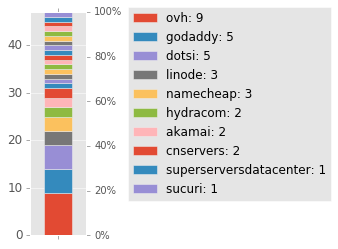

In [96]:
fig = plt.figure(figsize=(1, 4))
fig.subplots_adjust(hspace=0.5,wspace=0.3)

ax2 = plt.subplot2grid((1,1), (0,0))

ax1 = ax2.twinx()
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

booter_as_now_cloudflare.to_frame().T.plot(kind='bar',ax=ax2, legend=False, stacked=True, title="",fontsize=12).set_zorder(1)
ax2.set_xlabel("")
ax2.set_ylim(0,len(booter_actual_as.dropna()))

legend_show_top=10
labels = ['{0}: {1}'.format(i,j) for i,j in zip(booter_as_now_cloudflare.index, booter_as_now_cloudflare.values)]
ax2.legend(ax2.patches[0:legend_show_top], 
         labels[0:legend_show_top], 
           bbox_to_anchor=(5.5, 1.05),
           fontsize=12)

plt.setp( ax2.get_xticklabels(), visible=False)


fig.show()
fig.savefig(output_figures+'ases_incloudflare_stacked.eps', bbox_inches='tight',format='eps', dpi=1200)

## 11.10. Analysing ASes Behind CloudFlare (stacked bar & internal legend)

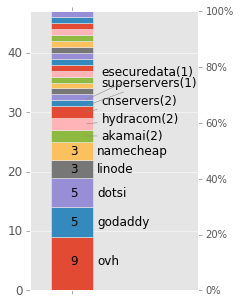

In [97]:
fig = plt.figure(figsize=(3, 5))
fig.subplots_adjust(hspace=0.5,wspace=0.3)

ax2 = plt.subplot2grid((1,1), (0,0))

ax1 = ax2.twinx()
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

booter_as_now_cloudflare.to_frame().T.plot(kind='bar',ax=ax2, legend=False, stacked=True, title="",fontsize=12,width=0.1).set_zorder(1)
ax2.set_xlabel("")
ax2.set_ylim(0,len(booter_actual_as.dropna()))
ax2.set_xlim(-.1,0.3)
plt.setp( ax2.get_xticklabels(), visible=False)


legend_show_top=10
labels = ['{0}: {1}'.format(i,j) for i,j in zip(booter_as_now_cloudflare.index, booter_as_now_cloudflare.values)]

ax2.text(0.06, 5,'ovh',ha="left", va="center",size=12)
ax2.text(0.005, 5,'9',ha="center", va="center",size=12)

ax2.text(0.06, 11.5,'godaddy',ha="left", va="center",size=12)
ax2.text(0.005, 11.5,'5',ha="center", va="center",size=12)

ax2.text(0.06, 16.5,'dotsi',ha="left", va="center",size=12)
ax2.text(0.005, 16.5,'5',ha="center", va="center",size=12)

ax2.text(0.06, 20.5,'linode',ha="left", va="center",size=12)
ax2.text(0.005, 20.5,'3',ha="center", va="center",size=12)

ax2.text(0.06, 23.5,'namecheap',ha="left", va="center",size=12)
ax2.text(0.005, 23.5,'3',ha="center", va="center",size=12)

ax2.annotate('akamai(2)',
             (0.03,26), xycoords='data',
             xytext=(0.07,26), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)

ax2.annotate('hydracom(2)',
             (0.03,28), xycoords='data',
             xytext=(0.07,29), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)

ax2.annotate('cnservers(2)',
             (0.03,30), xycoords='data',
             xytext=(0.07,32), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)

ax2.annotate('superservers(1)',
             (0.03,31), xycoords='data',
             xytext=(0.07,35), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)

ax2.annotate('esecuredata(1)',
             (0.03,32), xycoords='data',
             xytext=(0.07,38), textcoords='data',ha='left', va='top',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)



fig.show()
fig.savefig(output_figures+'ases_incloudflare_stacked_inlegend.eps', bbox_inches='tight',format='eps', dpi=1200)

## 11.11. Combining ASes in general and ASes behind CloudFlare (stacked bar)

In [101]:
merged_asn_cloudflare = asn.add(booter_as_now_cloudflare,fill_value=0).sort_values(ascending=False)
merged_asn_cloudflare['cloudflarenet']=76-47

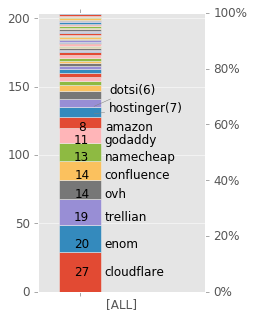

In [102]:
fig = plt.figure(figsize=(3, 5))
fig.subplots_adjust(hspace=0.5,wspace=0.3)
ax5 = plt.subplot2grid((1,1), (0,0))

ax4 = ax5.twinx()
ax4.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax4.tick_params(which='major', labelsize=12)

merged_asn_cloudflare.to_frame().T.plot(kind='bar',ax=ax5, legend=False, stacked=True, title="",fontsize=12,width=0.1).set_zorder(1)
ax5.set_xlabel("[ALL]")
ax5.set_ylim(0,merged_asn_cloudflare.sum())
ax5.set_xlim(-.1,0.3)
plt.setp( ax5.get_xticklabels(), visible=False)


legend_show_top=10
labels = ['{0}: {1}'.format(i,j) for i,j in zip(merged_asn_cloudflare.index, merged_asn_cloudflare.values)]

ax5.text(0.06, 15,'cloudflare',ha="left", va="center",size=12)
ax5.text(0.005, 15,'27',ha="center", va="center",size=12)

ax5.text(0.06, 35,'enom',ha="left", va="center",size=12)
ax5.text(0.005, 35,'20',ha="center", va="center",size=12)

ax5.text(0.06, 55,'trellian',ha="left", va="center",size=12)
ax5.text(0.005, 55,'19',ha="center", va="center",size=12)

ax5.text(0.06, 72,'ovh',ha="left", va="center",size=12)
ax5.text(0.005, 72,'14',ha="center", va="center",size=12)

ax5.text(0.06, 86,'confluence',ha="left", va="center",size=12)
ax5.text(0.005, 86,'14',ha="center", va="center",size=12)

ax5.text(0.06, 99,'namecheap',ha="left", va="center",size=12)
ax5.text(0.005, 99,'13',ha="center", va="center",size=12)

ax5.text(0.06, 111,'godaddy',ha="left", va="center",size=12)
ax5.text(0.005, 111,'11',ha="center", va="center",size=12)

ax5.text(0.06, 121,'amazon',ha="left", va="center",size=12)
ax5.text(0.005, 121,'8',ha="center", va="center",size=12)

ax5.annotate('hostinger(7)',
             (0.03,130), xycoords='data',
             xytext=(0.07,135), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)

ax5.annotate('dotsi(6)',
             (0.03,135), xycoords='data',
             xytext=(0.07,148), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)


fig.show()
fig.savefig(output_figures+'ases_+incloudflare_stacked.eps', bbox_inches='tight',format='eps', dpi=1200)

## 11.12. Combining all ASes and explain the process (stacked bar & internal legend)

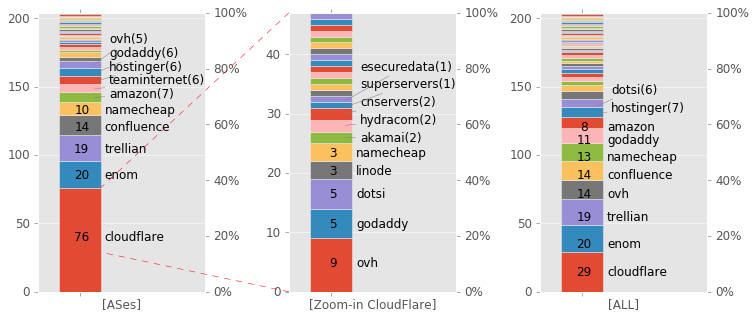

In [103]:
fig = plt.figure(figsize=(12, 5))
fig.subplots_adjust(hspace=0.5,wspace=0.5)

ax2 = plt.subplot2grid((1,3), (0,0))

ax1 = ax2.twinx()
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax1.tick_params(which='major', labelsize=12)


asn.to_frame().T.plot(kind='bar',ax=ax2, legend=False, stacked=True, title="",fontsize=12,width=0.1).set_zorder(1)
ax2.set_xlabel("[ASes]")
ax2.set_ylim(0,asn.sum())
ax2.set_xlim(-.1,0.3)

plt.setp( ax2.get_xticklabels(), visible=False)

ax2.text(0.06, 40,'cloudflare',ha="left", va="center",size=12)
ax2.text(0.005, 40,'76',ha="center", va="center",size=12)

ax2.text(0.06, 86,'enom',ha="left", va="center",size=12)
ax2.text(0.005, 86,'20',ha="center", va="center",size=12)

ax2.text(0.06, 105,'trellian',ha="left", va="center",size=12)
ax2.text(0.005, 105,'19',ha="center", va="center",size=12)

ax2.text(0.06, 121,'confluence',ha="left", va="center",size=12)
ax2.text(0.005, 121,'14',ha="center", va="center",size=12)

ax2.text(0.06, 133,'namecheap',ha="left", va="center",size=12)
ax2.text(0.005, 133,'10',ha="center", va="center",size=12)

ax2.annotate('amazon(7)',
             (0.03,142), xycoords='data',
             xytext=(0.07,145), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)

ax2.annotate('teaminternet(6)',
             (0.03,148), xycoords='data',
             xytext=(0.07,155), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)

ax2.annotate('hostinger(6)',
             (0.03,153), xycoords='data',
             xytext=(0.07,165), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)

ax2.annotate('godaddy(6)',
             (0.03,159), xycoords='data',
             xytext=(0.07,175), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
             size=12)

ax2.annotate('ovh(5)',
             (0.03,165), xycoords='data',
             xytext=(0.07,185), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)
###################################

ax4 = plt.subplot2grid((1,3), (0,1))

ax3 = ax4.twinx()
ax3.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax3.tick_params(which='major', labelsize=12)

booter_as_now_cloudflare.to_frame().T.plot(kind='bar',ax=ax4, legend=False, stacked=True, title="",fontsize=12,width=0.1).set_zorder(1)
ax4.set_xlabel("[Zoom-in CloudFlare]")
ax4.set_ylim(0,len(booter_actual_as.dropna()))
ax4.set_xlim(-.1,0.3)
plt.setp( ax4.get_xticklabels(), visible=False)


legend_show_top=10
labels = ['{0}: {1}'.format(i,j) for i,j in zip(booter_as_now_cloudflare.index, booter_as_now_cloudflare.values)]

ax4.text(0.06, 5,'ovh',ha="left", va="center",size=12)
ax4.text(0.005, 5,'9',ha="center", va="center",size=12)

ax4.text(0.06, 11.5,'godaddy',ha="left", va="center",size=12)
ax4.text(0.005, 11.5,'5',ha="center", va="center",size=12)

ax4.text(0.06, 16.5,'dotsi',ha="left", va="center",size=12)
ax4.text(0.005, 16.5,'5',ha="center", va="center",size=12)

ax4.text(0.06, 20.5,'linode',ha="left", va="center",size=12)
ax4.text(0.005, 20.5,'3',ha="center", va="center",size=12)

ax4.text(0.06, 23.5,'namecheap',ha="left", va="center",size=12)
ax4.text(0.005, 23.5,'3',ha="center", va="center",size=12)

ax4.annotate('akamai(2)',
             (0.03,26), xycoords='data',
             xytext=(0.07,26), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)

ax4.annotate('hydracom(2)',
             (0.03,28), xycoords='data',
             xytext=(0.07,29), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)

ax4.annotate('cnservers(2)',
             (0.03,30), xycoords='data',
             xytext=(0.07,32), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)

ax4.annotate('superservers(1)',
             (0.03,31), xycoords='data',
             xytext=(0.07,35), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)

ax4.annotate('esecuredata(1)',
             (0.03,32), xycoords='data',
             xytext=(0.07,38), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)

############
from matplotlib.patches import ConnectionPatch
con = ConnectionPatch(xyB=(0.05,29), coordsB="data", axesB=ax2,
                      xyA=(-0.1,0),  coordsA="data", axesA=ax4,
                      color='r',linestyle='dashed')

con2 = ConnectionPatch(xyB=(0.05,76), coordsB="data",axesB=ax2,
                       xyA=(-0.1,47), coordsA="data",axesA=ax4,
                       color='r',linestyle='dashed')

ax4.add_artist(con).set_zorder(1)
ax4.add_artist(con2).set_zorder(1)

#############
ax5 = plt.subplot2grid((1,3), (0,2))

ax4 = ax5.twinx()
ax4.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax4.tick_params(which='major', labelsize=12)

merged_asn_cloudflare.to_frame().T.plot(kind='bar',ax=ax5, legend=False, stacked=True, title="",fontsize=12,width=0.1).set_zorder(1)
ax5.set_xlabel("[ALL]")
ax5.set_ylim(0,merged_asn_cloudflare.sum())
ax5.set_xlim(-.1,0.3)
plt.setp( ax5.get_xticklabels(), visible=False)


legend_show_top=10
labels = ['{0}: {1}'.format(i,j) for i,j in zip(merged_asn_cloudflare.index, merged_asn_cloudflare.values)]

ax5.text(0.06, 15,'cloudflare',ha="left", va="center",size=12)
ax5.text(0.005, 15,'29',ha="center", va="center",size=12)

ax5.text(0.06, 35,'enom',ha="left", va="center",size=12)
ax5.text(0.005, 35,'20',ha="center", va="center",size=12)

ax5.text(0.06, 55,'trellian',ha="left", va="center",size=12)
ax5.text(0.005, 55,'19',ha="center", va="center",size=12)

ax5.text(0.06, 72,'ovh',ha="left", va="center",size=12)
ax5.text(0.005, 72,'14',ha="center", va="center",size=12)

ax5.text(0.06, 86,'confluence',ha="left", va="center",size=12)
ax5.text(0.005, 86,'14',ha="center", va="center",size=12)

ax5.text(0.06, 99,'namecheap',ha="left", va="center",size=12)
ax5.text(0.005, 99,'13',ha="center", va="center",size=12)

ax5.text(0.06, 111,'godaddy',ha="left", va="center",size=12)
ax5.text(0.005, 111,'11',ha="center", va="center",size=12)

ax5.text(0.06, 121,'amazon',ha="left", va="center",size=12)
ax5.text(0.005, 121,'8',ha="center", va="center",size=12)

ax5.annotate('hostinger(7)',
             (0.03,130), xycoords='data',
             xytext=(0.07,135), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)

ax5.annotate('dotsi(6)',
             (0.03,135), xycoords='data',
             xytext=(0.07,148), textcoords='data',ha='left', va='center',
             arrowprops=dict(arrowstyle='-',connectionstyle="arc3",color='grey'),
            size=12)


fig.show()
fig.savefig(output_figures+'ases_+incloudflare_+merged_stacked_inlegend.eps', bbox_inches='tight',format='eps', dpi=1200)

# Which Booters Cloudpiercer didn't find any IP address outside CloudFlare?

In [105]:
missing_booter=list(set(booters_cloudflare)-set(booter_actual_as['tested_domain_name']))
len(missing_booter),missing_booter

(29,
 ['onestress.com',
  'ddos-him.com',
  'vbooter.org',
  'hornystress.me',
  'reafstresser.ga',
  'bullstresser.com',
  'cnstresser.com',
  'logicstresser.net',
  'maximumstresser.com',
  'downthem.org',
  'pineapple-stresser.com',
  'booter.ninja',
  'layer7.pw',
  'boot4free.com',
  'heavystresser.com',
  'ts3booter.net',
  'onestresser.net',
  'beststresser.com',
  'neverddos.com',
  'databooter.com',
  'webbooter.com',
  'diebooter.net',
  'destressbooter.com',
  'instabooter.com',
  'k-stress.pw',
  'legionboot.com',
  'stresser.ru',
  'connectionstresser.com',
  'stresser.network'])

## 11.13. MANUAL test if de facto all the IPs found by CloudPiercer and resolved by TeamCymru are inside Cloudfare 

In [75]:
BOOTER_MANUAL_TEST='cnstresser.com'

display('CloudPiercer scanid:')
display(df_cloudpiercer[df_cloudpiercer['booter']==BOOTER_MANUAL_TEST])

display(df_cloudflare_booter_ips[df_cloudflare_booter_ips['tested_domain_name']==BOOTER_MANUAL_TEST])


'CloudPiercer scanid:'

,booter,scanid
63,cnstresser.com,2KU5TYK64A6WS5B6


,tested_domain_name,ip,asn,bgp_prefix,country,registry,info_date,as_name
165,cnstresser.com,104.31.68.33,13335.0,104.31.64.0/20,US,arin,2014-03-28,"CLOUDFLARENET - CloudFlare, Inc., US"
166,cnstresser.com,104.31.69.33,13335.0,104.31.64.0/20,US,arin,2014-03-28,"CLOUDFLARENET - CloudFlare, Inc., US"
167,cnstresser.com,104.31.68.33,13335.0,104.31.64.0/20,US,arin,2014-03-28,"CLOUDFLARENET - CloudFlare, Inc., US"
168,cnstresser.com,108.162.192.82,NaN,NaN,US,arin,2011-10-28,NaN
169,cnstresser.com,104.31.68.33,13335.0,104.31.64.0/20,US,arin,2014-03-28,"CLOUDFLARENET - CloudFlare, Inc., US"
170,cnstresser.com,104.31.69.33,13335.0,104.31.64.0/20,US,arin,2014-03-28,"CLOUDFLARENET - CloudFlare, Inc., US"
171,cnstresser.com,173.245.58.155,13335.0,173.245.58.0/24,US,arin,2010-12-28,"CLOUDFLARENET - CloudFlare, Inc., US"
172,cnstresser.com,173.245.59.219,13335.0,173.245.59.0/24,US,arin,2010-12-28,"CLOUDFLARENET - CloudFlare, Inc., US"
